Part C: Using a DNN to Estimate Area Of Future Fires
===
See paper (to be written) for further explanation, although this notebook will contain some explanation regarding the nature of the notebook's contents.

In [1]:
import pandas as pd

bushfires_df = pd.read_csv("/kaggle/input/yicte-bushfires-over-time/data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne
0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0
1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0
2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0
3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0
4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0
...,...,...,...,...,...,...,...
6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3
6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3
6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9
6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2


In [2]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [3]:
# Group by month, average/sum, add a 'year' feature
grouped_df = bushfires_df.groupby(pd.Grouper(freq='W', key='acq_date'))

df = pd.DataFrame()

df['scan'] = grouped_df['scan'].mean()
df['max_t_syd'] = grouped_df['max_t_syd'].mean()
df['max_t_bne'] = grouped_df['max_t_bne'].mean()
df['time_sin'] = grouped_df['time_sin'].first()
df['time_cos'] = grouped_df['time_cos'].first()
df['year'] = grouped_df['year'].first() - 2000 # we'll count the years since approx when the data starts.

df = df.dropna()

In [4]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [5]:
train_dataset

,scan,max_t_syd,max_t_bne,time_sin,time_cos,year
acq_date,,,,,,
2007-08-05,82.400000,18.542857,23.585714,-0.471160,-0.882048,7.0
2009-03-01,30.285714,26.157143,30.542857,0.801361,0.598181,9.0
2001-05-13,119.657143,19.485714,25.142857,0.816538,-0.577292,1.0
2009-04-26,87.614286,22.371429,27.742857,0.948362,-0.317191,9.0
2014-08-17,132.500000,17.057143,21.857143,-0.642055,-0.766659,14.0
...,...,...,...,...,...,...
2009-10-11,484.742857,18.800000,26.428571,-0.997325,0.073095,9.0
2001-04-29,99.928571,23.514286,27.571429,0.930724,-0.365723,1.0
2002-12-29,350.028571,23.871429,28.714286,-0.137279,0.990532,2.0


In [6]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu'), # Input layer
        tf.keras.layers.Dense(64, activation='relu'), # Hidden layer
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1) # Output layer
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.))
    return model

In [8]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [9]:
model = build_and_compile_model()

history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=0, epochs=1600)

In [10]:
pd.DataFrame(history.history)

,loss,val_loss
0,194.242813,171.551300
1,166.410706,154.017151
2,158.672867,153.708603
3,158.449341,153.388763
4,158.226974,153.180984
...,...,...
1595,107.766670,115.053009
1596,110.024666,113.592781
1597,107.786835,114.450523
1598,109.286636,110.813835


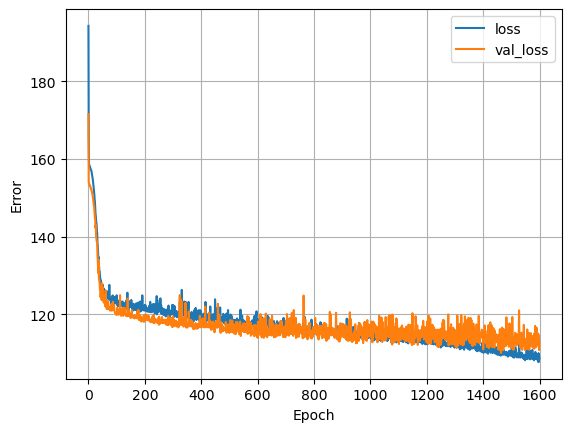

In [11]:
plot_loss(history)

7/7 [==============================] - 0s 2ms/step


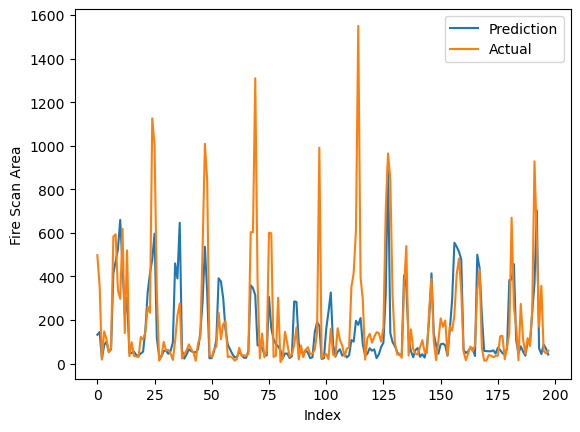

In [12]:
plt.plot(model.predict(test_features), label="Prediction")
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [13]:
# testing with some crazy data just because it's funny
new_data = {
    "max_t_syd": [34.023],
    "max_t_bne": [35.253],
    "time_sin": [0.017213],
    "time_cos": [0.999852],
    "year": [52.0]
}

new_df = pd.DataFrame(data=new_data)

model.predict(new_df)

1/1 [==============================] - 0s 24ms/step


array([[249.11516]], dtype=float32)

In [14]:
model.save("/kaggle/working/model.keras")

In [15]:
# testing that model loading works
import keras

loaded_model = keras.models.load_model('/kaggle/working/model.keras')

loaded_model.predict(new_df)

1/1 [==============================] - 0s 78ms/step


array([[249.11516]], dtype=float32)